In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
%matplotlib inline
import seaborn as sns
sns.set()
from matplotlib.backends.backend_pdf import PdfPages
#from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib.colors as col
import matplotlib as mpl
import scipy
import numpy as np #import for transposing
import math
from matplotlib import pylab as pl 
import mpld3 as ml
import math
from sklearn.metrics import mean_squared_error

In [17]:
new_census = pd.read_csv('new_census.csv')
new_census['Date'] = pd.to_datetime(new_census['Date'])
new_census['ObsYear'] = new_census.Date.apply(lambda x: x.year)
new_census['ObsMonth'] = new_census.Date.apply(lambda x:x.month)

new_census.T = pd.to_numeric(new_census['T'],errors='coerce')
new_census.J = pd.to_numeric(new_census.J)
new_census.A = pd.to_numeric(new_census.A)
new_census.S = pd.to_numeric(new_census.S)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


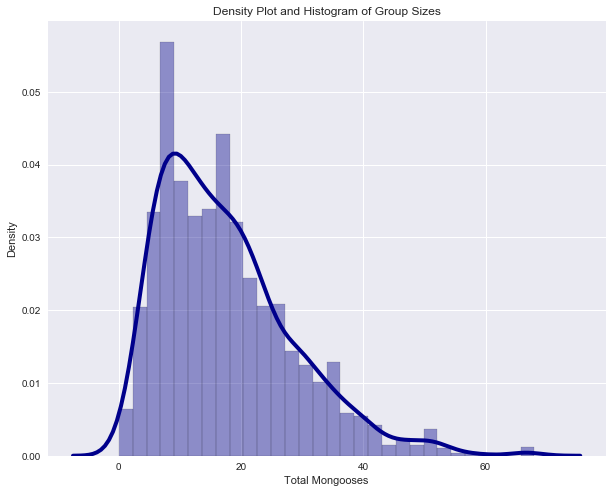

In [18]:
import seaborn as sns
data = new_census['T'].dropna()
fig,ax = plt.subplots(figsize=(10,8))
sns.distplot(data, hist=True, kde=True, 
             bins=int(30), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel('Total Mongooses')
plt.ylabel('Density')
plt.title('Density Plot and Histogram of Group Sizes')
plt.savefig('troop_density.png')

In [19]:
print('thresh range: [{},{}]'.format(int(np.percentile(data,5)),int(np.percentile(data,10))))

thresh range: [4,6]


In [20]:
print('fis_thresh: [{},{}]'.format(int(np.percentile(data,95)),int(np.percentile(data,100))))

fis_thresh: [38,68]


In [21]:

def stoch_model(J0=0,S10=0,S20=6,A0=15,years=1,log = 0,fus_fis= 0.4,no_ev = 0.6,rt_chg = 0.1,b_j = 0.5,d_j = 0.345,d_s = 0.214,d_a = 0.143,ae_j = 0.5,ae_s=0.5,ae_a=0.5,t_p = 0.3,por = 0.2,fsr = 0.4,thresh = 4,fis_thresh = 45,lit_size = 4,dfe='off'):

####################################################
####These are global variables within the function
    b_j = b_j ##recruitment/birth rate of juveniles
    
    d_j = d_j ##death rate of juveniles
    d_s = d_s ##death rate of subadults
    d_a = d_a ##death rate of adults
    

    ae_j = ae_j ##The allee-effect's effect on survival/transition of pups/juveniles
    ae_s = ae_s ##The allee-effect's effect on survival/transition of subadults
    ae_a = ae_a ##The allee-effect's effect on survival/transition of adults
    

    t_p = t_p ##Probability of transmission
    por = por ##Portion of population killed by infection
    fsr = fsr ##sex ratio for females to males
    msr = 1 - fsr ##sex ratio for males to females
    fsr = 1-msr ##Fixes logic problems in fusion/fission
    thresh = thresh ##Thresh for AE to take effect
    fis_thresh = fis_thresh ##Thresh for fission to occur
    lit_size = lit_size ##average litter size
    
    no_ev = no_ev ##probability of no fusion/fission event occurring
    rt_chg = rt_chg ##the amount that sex ratio (m or f) changes during a fusion/fission event
    fus_fis = fus_fis ##probability that a fusion will occur onto the existing group (another group's fission added to current group)
    
    ND=MaxTime=years

    INPUT = np.array((J0,S10,S20,A0)) 
    

    ##Model Run    
    #Param values are called from very beginning of code block
    if log == 0:
        [T,J,S1,S2,A]=Stoch_Iteration(INPUT,log=log,dfe=dfe,ND=ND,fus_fis = fus_fis,no_ev = no_ev,rt_chg = rt_chg,b_j = b_j,d_j = d_j,d_s = d_s,d_a = d_a,ae_j = ae_j,ae_s = ae_s,ae_a = ae_a,t_p = t_p,por = por,fsr = fsr,thresh = thresh,fis_thresh = fis_thresh,lit_size = lit_size)
    else:
        [T,J,S1,S2,A,log_df]=Stoch_Iteration(INPUT,log=log,dfe=dfe,ND=ND,fus_fis = fus_fis,no_ev = no_ev,rt_chg = rt_chg,b_j = b_j,d_j = d_j,d_s = d_s,d_a = d_a,ae_j = ae_j,ae_s = ae_s,ae_a = ae_a,t_p = t_p,por = por,fsr = fsr,thresh = thresh,fis_thresh = fis_thresh,lit_size = lit_size)


    def add_qtr(x):
        if x <= 0.25:
            return 1
        elif (x>0.25)&(x<=0.5):
            return 2
        elif (x>0.5)&(x<=0.75):
            return 3
        else:
            return 4
        
    sim = pd.DataFrame(data={'tdate':T[1:],'J':J[1:],'S1':S1[1:],'S2':S2[1:],'A':A[1:]})
    sim['S'] = sim[['S1','S2']].sum(axis=1)
    sim['T'] = sim[['J','S','A']].sum(axis=1)
    sim = sim[['T','J','S','A','tdate']]
    sim['quarter'] = sim.tdate.apply(lambda x: add_qtr(x))

    if log ==0:
        return sim
    else:
        return sim,log_df    
    
###############################################





In [22]:
##Note:  higher group size increases pup survival (escorts) 
##Note: Pups need to be extinct by dry season (transitioned or death occurs)
##Note: Total end population should not be 
##Stoch Function
    
def stoc_eqs(INP,ts,qtr,time,pulse,dfe='off',fus_fis= 0.4,no_ev = 0.6,rt_chg = 0.1,b_j = 0.5,d_j = 0.345,d_s = 0.214,d_a = 0.143,ae_j = 0.5,ae_s=0.5,ae_a=0.5,t_p = 0.3,por = 0.2,fsr = 0.4,thresh = 4,fis_thresh = 45,lit_size = 4): 
    msr = 1- fsr
    V = INP
    if dfe == 'off':
        Rate=np.zeros((9))
        Change=np.zeros((9,4))
    else:
        Rate=np.zeros((8))
        Change=np.zeros((8,4))
    N=np.sum(V[range(4)])

    s_j = 1 - d_j
    s_s = 1 - d_s
    s_a = 1 - d_a
    ##V[0] = Juv | V[1] = Sub1 | V[2] = Sub2 | V[3] = Adult

    if np.sum(INP) > thresh: #above thresh

        ##1st qtr during wet season (above thresh)
        if qtr == 1: ##qtr = 1 => We assume we've found a cohort with all of these age classes present

            Rate[0] = 0; Change[0,:]=([0, 0, 0, 0]);##no additions to juv until after 1st qtr
            Rate[1] = 0; Change[1,:] = ([0, 0, 0, 0]); ##no juvs present until after 1st qtr
            Rate[2] = 0; Change[2,:] = ([0, 0, 0, 0]); ##no juvs present until after 1st qtr
            Rate[3] = 0; Change[3,:] = ([0, 0, 0, 0]); ##no sub1 present until after 2nd qtr
            Rate[4] = 0; Change[4,:] = ([0, 0, 0, 0]); ##no sub1 present until after 2nd qtr
            Rate[5] = s_s*V[2]; Change[5,:] = ([0, 0, -s_s*V[2], +s_s*V[2]]);
            Rate[6] = d_s*V[2]; Change[6,:] = ([0, 0, -d_s*V[2], 0]);
            Rate[7] = d_a*V[3]; Change[7,:] = ([0, 0, 0, -d_a*V[3]]);
            if dfe == 'off':
                ##Reaction for infection (mortality only occurs during dry season)
                Rate[8] = 0; Change[8,:] = ([0, 0, 0, 0]);     

        ##2nd qtr during wet season (above thresh)
        ##pups survived 1st qtr and juvs can be added
        elif qtr == 2: 
            Rate[0] = b_j*(4*fsr*V[3]); Change[0,:]=([+lit_size*fsr*V[3], 0, 0, 0]);
            Rate[1] = s_j*V[0]; Change[1,:] = ([-s_j*V[0], +s_j*V[0], 0, 0]);
            Rate[2] = d_j*V[0]; Change[2,:] = ([-d_j*V[0], 0, 0, 0]);
            Rate[3] = 0; Change[3,:] = ([0, 0, 0, 0]); ##no sub1 present until after 2nd qtr
            Rate[4] = 0; Change[4,:] = ([0, 0, 0, 0]); ##no sub1 present until after 2nd qtr
            Rate[5] = 0; Change[5,:] = ([0, 0, 0, 0]); ##no sub2 again until 4th qtr
            Rate[6] = 0; Change[6,:] = ([0, 0, 0, 0]); ##no sub2 again until 4th qtr
            Rate[7] = d_a*V[3]; Change[7,:] = ([0, 0, 0, -d_a*V[3]]);
            if dfe == 'off':
                ##Reaction for infection  (mortality only occurs during dry season)
                Rate[8] = 0; Change[8,:] = ([0, 0, 0, 0]);
            if np.sum(Change[0,:]) > 0:
                pulse += 1 ##Pulse tracks whether or not a birth pulse has occurred

        ##3rd qtr during dry season (above thresh)
        elif qtr == 3:
        #print("dry")  
            if time%1 > 0.5: #is time past April?
                Rate[0] = 0; Change[0,:]=([0, 0, 0, 0]); ##no more juv additions after April
            else:
                Rate[0] = b_j*(4*fsr*V[3]); Change[0,:]=([+lit_size*fsr*V[3], 0, 0, 0]) ##no more juv additions after April

            if time%1 > 8./12: #is time past June?
                Rate[1] = 0; Change[1,:] = ([0, 0, 0, 0]); ##no more transitioning after June
                Rate[2] = 0; Change[2,:] = ([0, 0, 0, 0]); ##no juv death since all juvs transitioned
            else:
                Rate[1] = s_j*V[0]; Change[1,:] = ([-s_j*V[0], +s_j*V[0], 0, 0]); ##juv transitioning occurs before June
                Rate[2] = d_j*V[0]; Change[2,:] = ([-d_j*V[0], 0, 0, 0]);
                ##will need to include logic transition b/c of this conditional

            Rate[3] = s_s*V[1]; Change[3,:] = ([0, -s_s*V[1], +s_s*V[1], 0]);
            Rate[4] = d_s*V[1]; Change[4,:] = ([0, -d_s*V[1], 0, 0]);
            Rate[5] = 0; Change[5,:] = ([0, 0, 0, 0]); ##no sub2 again until 4th qtr
            Rate[6] = 0; Change[6,:] = ([0, 0, 0, 0]); ##no sub2 again until 4th qtr
            Rate[7] = d_a*V[3]; Change[7,:] = ([0, 0, 0, -d_a*V[3]]);
            if dfe == 'off':
                ##Reaction for infection
                Rate[8] = t_p*np.sum(V); Change[8,:] = ([0, 0, 0, -por*V[3]]);
            if np.sum(Change[0,:]) > 0:
                pulse += 1

        ##4th qtr during dry season (above thresh)
        elif qtr == 4:
            Rate[0] = 0; Change[0,:]=([0, 0, 0, 0]);   ##No juvenile transition during 4th quarter
            Rate[1] = 0; Change[1,:] = ([0, 0, 0, 0]); ##no more juvs
            Rate[2] = 0; Change[2,:] = ([0, 0, 0, 0]); ##no more juvs

            if time%1 > 11./12: #is time past September?
                Rate[3] = 0; Change[3,:] = ([0, 0, 0, 0]); ##no sub1 after Sept.
                Rate[4] = 0; Change[4,:] = ([0, 0, 0, 0]); ##no sub1 after Sept.
            else:
                Rate[3] = s_s*V[1]; Change[3,:] = ([0, -s_s*V[1], +s_s*V[1], 0]);
                Rate[4] = d_s*V[1]; Change[4,:] = ([0, -d_s*V[1], 0, 0]);
                ##will need to include logic transition b/c of this conditional

            Rate[5] = s_s*V[2]; Change[5,:] = ([0, 0, -s_s*V[2], +s_s*V[2]]);
            Rate[6] = d_s*V[2]; Change[6,:] = ([0, 0, -d_s*V[2], 0]);
            Rate[7] = d_a*V[3]; Change[7,:] = ([0, 0, 0, -d_a*V[3]]);
            if dfe == 'off':
                ##Reaction for infection
                Rate[8] = t_p*np.sum(V); Change[8,:] = ([0, 0, -por*V[2], -por*V[3]]);

    else: #below thresh

        ##Quantifying Allee Effect
        d_j = ae_j*d_j
        s_j = 1 - d_j

        d_s = ae_s*d_s
        s_s = 1-d_s

        d_a = ae_a*d_a

        ##1st qtr during wet season (below thresh)
        if qtr == 1: ##qtr = 1 => We assume we've found a cohort with all of these age classes present

            Rate[0] = 0; Change[0,:]=([0, 0, 0, 0]);##no additions to juv until after 1st qtr
            Rate[1] = 0; Change[1,:] = ([0, 0, 0, 0]); ##no juvs present until after 1st qtr
            Rate[2] = 0; Change[2,:] = ([0, 0, 0, 0]); ##no juvs present until after 1st qtr
            Rate[3] = 0; Change[3,:] = ([0, 0, 0, 0]); ##no sub1 present until after 2nd qtr
            Rate[4] = 0; Change[4,:] = ([0, 0, 0, 0]); ##no sub1 present until after 2nd qtr
            Rate[5] = s_s*V[2]; Change[5,:] = ([0, 0, -s_s*V[2], +s_s*V[2]]);
            Rate[6] = d_s*V[2]; Change[6,:] = ([0, 0, -d_s*V[2], 0]);
            Rate[7] = d_a*V[3]; Change[7,:] = ([0, 0, 0, -d_a*V[3]]);
            if dfe == 'off':
                ##Reaction for infection (mortality only occurs during dry season)
                Rate[8] = 0; Change[8,:] = ([0, 0, 0, 0]);     

        ##2nd qtr during wet season (above thresh)
        ##pups survived 1st qtr and juvs can be added
        elif qtr == 2: 
            Rate[0] = b_j*(4*fsr*V[3]); Change[0,:]=([+lit_size*fsr*V[3], 0, 0, 0]);
            Rate[1] = s_j*V[0]; Change[1,:] = ([-s_j*V[0], +s_j*V[0], 0, 0]);
            Rate[2] = d_j*V[0]; Change[2,:] = ([-d_j*V[0], 0, 0, 0]);
            Rate[3] = 0; Change[3,:] = ([0, 0, 0, 0]); ##no sub1 present until after 2nd qtr
            Rate[4] = 0; Change[4,:] = ([0, 0, 0, 0]); ##no sub1 present until after 2nd qtr
            Rate[5] = 0; Change[5,:] = ([0, 0, 0, 0]); ##no sub2 again until 4th qtr
            Rate[6] = 0; Change[6,:] = ([0, 0, 0, 0]); ##no sub2 again until 4th qtr
            Rate[7] = d_a*V[3]; Change[7,:] = ([0, 0, 0, -d_a*V[3]]);
            if dfe == 'off':
                ##Reaction for infection  (mortality only occurs during dry season)
                Rate[8] = 0; Change[8,:] = ([0, 0, 0, 0]);
            if np.sum(Change[0,:]) > 0:
                pulse += 1 ##Pulse tracks whether or not a birth pulse has occurred

        ##3rd qtr during dry season (above thresh)
        elif qtr == 3:
        #print("dry")  
            if time%1 > 0.5: #is time past April?
                Rate[0] = 0; Change[0,:]=([0, 0, 0, 0]); ##no more juv additions after April
            else:
                Rate[0] = b_j*(4*fsr*V[3]); Change[0,:]=([+lit_size*fsr*V[3], 0, 0, 0]) ##no more juv additions after April

            if time%1 > 8./12: #is time past June?
                Rate[1] = 0; Change[1,:] = ([0, 0, 0, 0]); ##no more transitioning after June
                Rate[2] = 0; Change[2,:] = ([0, 0, 0, 0]); ##no juv death since all juvs transitioned
            else:
                Rate[1] = s_j*V[0]; Change[1,:] = ([-s_j*V[0], +s_j*V[0], 0, 0]); ##juv transitioning occurs before June
                Rate[2] = d_j*V[0]; Change[2,:] = ([-d_j*V[0], 0, 0, 0]);
                ##will need to include logic transition b/c of this conditional

            Rate[3] = s_s*V[1]; Change[3,:] = ([0, -s_s*V[1], +s_s*V[1], 0]);
            Rate[4] = d_s*V[1]; Change[4,:] = ([0, -d_s*V[1], 0, 0]);
            Rate[5] = 0; Change[5,:] = ([0, 0, 0, 0]); ##no sub2 again until 4th qtr
            Rate[6] = 0; Change[6,:] = ([0, 0, 0, 0]); ##no sub2 again until 4th qtr
            Rate[7] = d_a*V[3]; Change[7,:] = ([0, 0, 0, -d_a*V[3]]);
            if dfe == 'off':
                ##Reaction for infection
                Rate[8] = t_p*np.sum(V); Change[8,:] = ([0, 0, 0, -por*V[3]]);
            if np.sum(Change[0,:]) > 0:
                pulse += 1

        ##4th qtr during dry season (above thresh)
        elif qtr == 4:
            Rate[0] = 0; Change[0,:]=([0, 0, 0, 0]);   ##No juvenile transition during 4th quarter
            Rate[1] = 0; Change[1,:] = ([0, 0, 0, 0]); ##no more juvs
            Rate[2] = 0; Change[2,:] = ([0, 0, 0, 0]); ##no more juvs

            if time%1 > 11./12: #is time past September?
                Rate[3] = 0; Change[3,:] = ([0, 0, 0, 0]); ##no sub1 after Sept.
                Rate[4] = 0; Change[4,:] = ([0, 0, 0, 0]); ##no sub1 after Sept.
            else:
                Rate[3] = s_s*V[1]; Change[3,:] = ([0, -s_s*V[1], +s_s*V[1], 0]);
                Rate[4] = d_s*V[1]; Change[4,:] = ([0, -d_s*V[1], 0, 0]);
                ##will need to include logic transition b/c of this conditional

            Rate[5] = s_s*V[2]; Change[5,:] = ([0, 0, -s_s*V[2], +s_s*V[2]]);
            Rate[6] = d_s*V[2]; Change[6,:] = ([0, 0, -d_s*V[2], 0]);
            Rate[7] = d_a*V[3]; Change[7,:] = ([0, 0, 0, -d_a*V[3]]);
            if dfe == 'off':
                ##Reaction for infection
                Rate[8] = t_p*np.sum(V); Change[8,:] = ([0, 0, -por*V[2], -por*V[3]]);



    R1=pl.rand();
    R2=pl.rand();
    ts = -np.log(R2)/(np.sum(Rate)); ##Gillespie SSA
    #################################################################################################
    ##Implementing Changes

    m=min(find(pl.cumsum(Rate)>=R1*pl.sum(Rate)));
    V[range(4)]=V[range(4)]+Change[m,:]
    return [V,ts,pulse]


In [23]:
#########################################
##Model Evaluation
def Stoch_Iteration(INPUT,log=0,dfe='off',ND=1,fus_fis= 0.4,no_ev = 0.6,rt_chg = 0.1,b_j = 0.5,d_j = 0.345,d_s = 0.214,d_a = 0.143,ae_j = 0.5,ae_s=0.5,ae_a=0.5,t_p = 0.3,por = 0.2,fsr = 0.4,thresh = 4,fis_thresh = 45,lit_size = 4):

    lop=0
    ts=0
    T=[0]
    J=[0]
    S1=[0]
    S2=[0]
    A=[0]
    qt = 0
    pulse = 0
    fsr = fsr
    msr = 1 - fsr

    ran = np.array((0,0.25,0.5,0.75,1))
    qtr = np.array((0,0.25,0.5,0.75,1))

    ##A log for error messages
    if log > 0:
        log_df = pd.DataFrame(columns=['Message','Time'])

    while T[lop] < ND:
        lop=lop+1
        T.append(T[lop-1]+ts)
        ###############################################
        ###Transitioning remaining classes (for logic)
        S2_logic = 0

        ##Determining and Indicationg Quarter of Year
        try:
            if ND == 1:
                if (T[lop] <= qtr[1]) & (T[lop] >= qtr[0]):
                    qt = 1
                elif (T[lop] <= qtr[2]) & (T[lop] > qtr[1]):
                    qt = 2
                elif (T[lop] <= qtr[3]) & (T[lop] > qtr[2]):
                    qt = 3
                elif (T[lop] <= qtr[4]) & (T[lop] > qtr[3]):
                    qt = 4
                    pulse = 0
            else:
                if (T[lop]%1 <= qtr[1]) & (T[lop]%1 >= qtr[0]):
                    qt = 1
                elif (T[lop]%1 <= qtr[2]) & (T[lop]%1 > qtr[1]):
                    qt = 2
                elif (T[lop]%1 <= qtr[3]) & (T[lop]%1 > qtr[2]):
                    qt = 3
                elif (T[lop]%1 <= qtr[4]) & (T[lop]%1 > qtr[3]):
                    qt = 4
                    pulse = 0
        except:
            print('lop: {}'.format(lop))
            print(T)
        #############################################
        ##Running and recieving data for time step   
        [res,ts,pulse] = stoc_eqs(INPUT,ts,qt,T[lop],pulse,dfe=dfe,fus_fis = fus_fis,no_ev = no_ev,rt_chg = rt_chg,b_j = b_j,d_j = d_j,d_s = d_s,d_a = d_a,ae_j = ae_j,ae_s = ae_s,ae_a = ae_a,t_p = t_p,por = por,fsr = fsr,thresh = thresh,fis_thresh = fis_thresh,lit_size = lit_size)

        ###############################################
        ##Force birth to occur at least once a year (if it hasn't already)
        if (qt == 3) & (pulse == 0) & (np.sum(res) > 0):
            J[-1] = lit_size*fsr*A[-1] 
            res[0] = J[-1]
            pulse = 1
            if log > 0:
                log_df = log_df.append(pd.DataFrame({'Message':['force birth occurred'],'Time':[T[lop]]}))


        #######################################################
        ##Fusion/Fission changes occur here
        ##NEED TO ADD STOCHASTICITY
        ##NEED TO ADD LOGIC CONTROL FOR FSR,MSR < 1 & FSR+MSR = 1
        ##CONFIRM EVICTIONS OCCUR DURING WET SEASON/BREEDING
        fus_fis = fus_fis
        fis_thresh = fis_thresh
        rt_chg = rt_chg
        fiss_test = 0
        ev = pl.rand()



        ##Evictions only occur during wet season
        if (qt == 1) | (qt == 2):

            ###Split for troop too large
            ######This is for when the troop is too large and a portion of the group leaves######
            if np.sum(res) >= fis_thresh:
                if log>0:
                    log_df = log_df.append(pd.DataFrame({'Message':['Fission occurred: Troop too large'], 'Time': [T[lop]]}))
                    log_df = log_df.append(pd.DataFrame({'Message':['Adult Pop: Before:{} | After:{}'.format(res[3],int(round(0.76*res[3])))], 'Time': [T[lop]]}))
                res[3] = 0.76*res[3] ##remove 24% of adults

                ###Adjusting sex ratio (troop too big)###
                if fsr > msr: ##more females than males
                    fsr -= rt_chg ##male ratio increases (fsr dec.)
                    if log>0:
                        log_df = log_df.append(pd.DataFrame({'Message':['Male ratio increased'],'Time':[T[lop]]}))

                elif fsr < msr: ##more males than females
                    msr -= rt_chg ##female ratio increases (msr dec.)
                    if log>0:
                        log_df = log_df.append(pd.DataFrame({'Message':['Female ratio increased'],'Time':[T[lop]]}))

                else:
                    choose= pl.rand()
                    if choose <= 2./3: ##randomly choose female ratio to increase (0.67 because Cant2016 said females twice as likely to be evicted)
                        fsr += rt_chg
                        if log>0:
                            log_df = log_df.append(pd.DataFrame({'Message':['Female ratio increased'],'Time':[T[lop]]}))

                    else: ##randomly choose male ratio to increase
                        fsr -= rt_chg
                        if log>0:
                            log_df = log_df.append(pd.DataFrame({'Message':['Male ratio increased'],'Time':[T[lop]]}))


            ##Stochastically determining whether a fusion occurs onto existing group
            if ev <= fus_fis:
                ##Fusion
                ###This is for when a group isn't too big to accept another group's fission into its own group###
                if np.sum(res) < fis_thresh:
                    add = pl.randint(1,4)
                    res[3] += add 
                    if log>0:
                        log_df = log_df.append(pd.DataFrame({'Message':['Fusion occurred: {} adults added'.format(add)], 'Time':[T[lop]]}))

                    ##Adjusting sex ratio (fusion)
                    if fsr > msr: ##more females than males
                        fsr -= rt_chg ##male ratio increases (fsr dec.)
                        if log>0:
                            log_df = log_df.append(pd.DataFrame({'Message':['Males increased'],'Time':[T[lop]]}))

                    elif fsr < msr: ##more males than females
                        msr -= rt_chg ##female ratio increases (msr dec.)
                        if log>0:
                            log_df = log_df.append(pd.DataFrame({'Message':['Females increased'],'Time':[T[lop]]}))

                    else:
                        choose= pl.rand()
                        if choose <= 0.75: ##randomly choose female ratio to increase (0.75 because Cant2016 said females twice as likely to be evicted)
                            fsr += rt_chg
                            if log>0:
                                log_df = log_df.append(pd.DataFrame({'Message':['Females increased'],'Time':[T[lop]]}))
                        else: ##randomly choose male ratio to increase
                            fsr -= rt_chg
                            if log>0:
                                log_df = log_df.append(pd.DataFrame({'Message':['Males increased'],'Time':[T[lop]]}))



        ###############################################
        ###Transitioning remaining classes (for logic)
        if fiss_test == 0:
            S2_logic = 0


            if T[lop-1]%1 >= 8./12: #if time is past June (see transition diagram on board)
                if len(J) > 1:
                    if T[lop-1]%1 >= 11./12:#if time is past September
                        S2_end = round(res[2] + res[1]) ##move all S1 to S2
                        S2.append(S2_end)
                        S1.append(0)
                        S2_logic = 1
                        J.append(round(res[0]))

                    else: #time past June before September
                        S1_end = round(res[1] + res[0]) ##move all J to S1
                        S1.append(S1_end)
                        J.append(0)

            else:
                J.append(round(res[0]))
                S1.append(round(res[1]))

            ###############################################
            if (qt == 1) & (T[lop-1]>=1): ##if past first year in first quarter
                A_end = round(res[2] + res[3]) ##move all S2 to A
                A.append(A_end)
                S2.append(0)

            else:
                if S2_logic == 0: ##if S2 hasn't been appended yet
                    S2.append(round(res[2])) ##append S2
                    A.append(round(res[3]))

                else:
                    A.append(round(res[3]))
    if log==0:        
        return [T,J,S1,S2,A]

    else:
        return [T,J,S1,S2,A,log_df]

###############################################

In [24]:
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

In [25]:
sim,log = stoch_model(log=1)
import import_ipynb
from function_log import add_tdate,get_week,density_interp,extract_date,qtr_comp,IC_run_sim,new_compare,run_sim
log = log.reset_index(drop=True)
log.loc[:,'Date'] = log['Time'].dropna().apply(lambda x: extract_date(x))
log

,Message,Time,Date
0,Fusion occurred: 2 adults added,0.183756,2017-01-07 06:00:00
1,Females increased,0.183756,2017-01-07 06:00:00
2,Fusion occurred: 2 adults added,0.213433,2017-01-17 06:00:00
3,Females increased,0.213433,2017-01-17 06:00:00


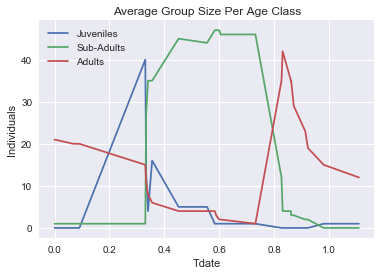

In [26]:
names = ['T','J','S','A']
lab = ['Total','Juveniles','Sub-Adults','Adults']
sim = stoch_model()

for i in range(3):
    plt.plot(sim.tdate,sim[names[i+1]],label=lab[i+1])
    plt.legend()
    plt.title('Average Group Size Per Age Class')
    plt.xlabel('Tdate')
    plt.ylabel('Individuals')

Text(0.5,0.98,'Average Values per Week')

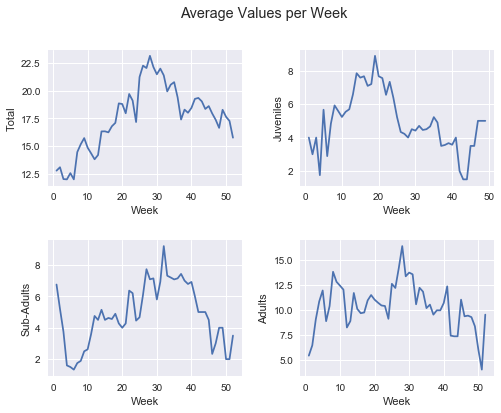

In [27]:
##A plot of average group size per week
avg=(new_census.groupby('week').mean().reset_index())
avg = avg.loc[avg.week < 53]

fig, axs = plt.subplots(2,2,figsize=(8,6))
fig.subplots_adjust(hspace = .4, wspace=.3)

axs = axs.ravel()

for i in range(4):
    axs[i].plot(avg.week,avg[names[i]])
    axs[i].set_ylabel(lab[i])
    axs[i].set_xlabel('Week')
    
plt.suptitle('Average Values per Week')

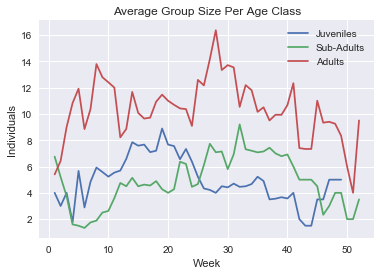

In [28]:
for i in range(3):
    plt.plot(avg.week,avg[names[i+1]],label=lab[i+1])
    plt.legend()
    plt.title('Average Group Size Per Age Class')
    plt.xlabel('Week')
    plt.ylabel('Individuals')